In [156]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import morphology
from skimage import data, exposure, img_as_float
from skimage.filters import threshold_local
from skimage.filters import gaussian
from skimage import io, color, measure, draw, img_as_bool
from scipy import ndimage as ndi
import pandas as pd
from skimage.feature import canny

In [157]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [158]:
def save_image(image, name):
    plt.imsave(name, image, cmap='gray')
    plt.close()

In [159]:
def normalize_image(image):
    return (image - 0.0) / (255.0 - 0.0)

In [160]:
def process_image(image, convert = True):
    if np.max(image) <= 1.0:
        image = image * 255
    if convert:
        image = image.astype(np.uint8)
    return image

In [161]:
# num_image = 15
# path = f'database/{num_image}.pgm'
# prueba1 = cv2.imread(path)
# prueba1 = prueba1[:, :, 0]
# prueba1 = normalize_image(prueba1)
# gt_1_p = f'database/{num_image}_gt.pgm'
# gt_1 = cv2.imread(gt_1_p, 0)
# gt_1 = normalize_image(gt_1)
# print(prueba1.shape, gt_1.shape)

In [162]:
# show_image(prueba1)
# show_image(gt_1)

In [163]:

def sharpen(image):
    sigma = 1  # El valor de sigma debe ser ajustado según tus necesidades
    blurred = gaussian(image, sigma=sigma)

    # Crear la máscara de desenfoque (Unsharp mask)
    amount = 1  # Este valor puede ajustarse para aumentar o disminuir el efecto
    sharpened = image + (image - blurred) * amount

    # Asegurarse de que los datos de la imagen están en el rango [0, 1]
    sharpened = np.clip(sharpened, 0, 1)

    return sharpened

In [164]:
def sharpening_filter(image):
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    return cv2.filter2D(image, -1, kernel)

In [165]:
def gaussian_filter(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

In [166]:
def laplacian_filter(image):
    return cv2.Laplacian(image, cv2.CV_64F)

In [167]:
def LoG_filter(image, sigma=2):
    image = process_image(image)
    return cv2.GaussianBlur(laplacian_filter(image), (25, 25), sigma)

In [168]:
def threshold_LoG(image, threshold):
    image *= 255
    image = image.astype(np.uint8)
    _, image = cv2.threshold(image, threshold, 1, cv2.THRESH_BINARY)
    return image

In [169]:
# def morphological_smoothing(image):
#     kernel = morphology.square(4)
#     image = morphology.opening(image, kernel)
#     image = morphology.closing(image, kernel)
#     return image

In [170]:
# def mixture_of_gaussians(image):
#     image = image * 255
#     image = image.astype(np.uint8)
#     th =  cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5)
#     return th

In [171]:
# from sklearn.mixture import GaussianMixture
# def mog_binarization(image, n_components=2, max_iter=100):
#     image = image * 255
#     image = image.astype(np.uint8)
#     img_flat = image.reshape((-1, 1))
    
#     # Initialize Gaussian Mixture Model
#     gmm = GaussianMixture(n_components=n_components, max_iter=max_iter, covariance_type='tied')
    
#     # Fit the GMM to the image data
#     gmm.fit(img_flat)
    
#     # Predict the component labels (0 for background, 1 for foreground)
#     labels = gmm.predict(img_flat)
    
#     # Reshape labels back to the original image shape
#     segmented_img = labels.reshape(image.shape)
    
#     # Assuming the larger portion is the background, identify it
#     background_label = 0 if np.sum(segmented_img == 0) > np.sum(segmented_img == 1) else 1
    
#     # Create a binary image by assigning the foreground to 1 and the background to 0
#     binary_img = np.where(segmented_img == background_label, 0, 1).astype(np.uint8)
    
#     return binary_img

In [172]:
def isolate_area(image, level=0.8):
    gray_image = normalize_image(image)
    edges = measure.find_contours(gray_image, level=level)
    # Asumiendo que el contorno más grande es el borde de interés
    largest_contour = max(edges, key=len)

    # Crear una máscara del interior del contorno
    mask = np.zeros(gray_image.shape, dtype=bool)
    rr, cc = draw.polygon(largest_contour[:, 0], largest_contour[:, 1], mask.shape)
    mask[rr, cc] = True

    # Rellenar posibles agujeros en la máscara para asegurar que el interior esté completamente cubierto
    mask_filled = ndi.binary_fill_holes(mask)

    # Aplicar la máscara a la imagen para aislar el área de interés
    isolated_area = img_as_bool(mask_filled) * gray_image

    isolated_area = np.where(isolated_area > 0.9, 1, 0)
    return isolated_area

In [173]:
def equalize_hist(image):
    return cv2.equalizeHist((image * 255).astype(np.uint8))

In [174]:
def normalize_image2(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

In [175]:
def median_filter(image):
    image = process_image(image)
    return cv2.medianBlur(image, 5)

In [176]:
def closing(image):
    kernel = morphology.disk(4)
    return morphology.closing(image, kernel)

In [177]:
def pipeline(image, level=0.8, sigma=2):
    sharpened = sharpen(image)
    laplaced = LoG_filter(sharpened, sigma=sigma)
    laplaced = normalize_image2(laplaced)
    laplaced = equalize_hist(laplaced)
    isolated = isolate_area(laplaced, level)
    medianed = median_filter(isolated)
    return medianed

In [178]:
def gamma_correction(image, gamma=1.0):
    image = process_image(image)
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

In [179]:
# sharpened = sharpen(prueba1)
# from skimage import io, filters
# sigma = 2 
# show_image(sharpened)

In [180]:
# clahe = exposure.equalize_adapthist(sharpened, clip_limit=0.03)
# show_image(clahe)

In [181]:
# laplaced = LoG_filter(sharpened, sigma=4)
# laplaced = normalize_image2(laplaced)
# laplaced = equalize_hist(laplaced)
# # laplaced = otsu_binaria(laplaced)
# # laplaced *= 255
# # laplaced = laplaced.astype(np.uint8)
# # laplaced = median_filter(laplaced)
# show_image(laplaced)

In [182]:

# isolated_area = isolate_area(laplaced, 0.9)
# show_image(isolated_area)

In [183]:
# binarized = median_filter(isolated_area)
# show_image(binarized)

In [184]:
def compute_metrics(gt, image):
    gt = process_image(gt)
    image = process_image(image)
    gt = np.where(gt == 0, 0, 1)
    image = np.where(image == 0, 0, 1)
    tn, fp, fn, tp = confusion_matrix(gt.ravel(), image.ravel()).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, recall, specificity, precision, f1

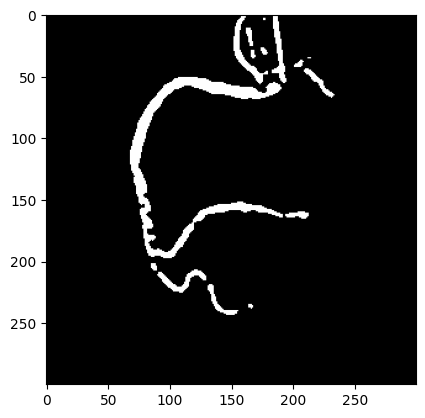

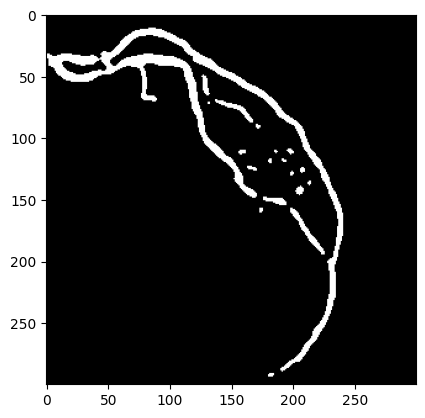

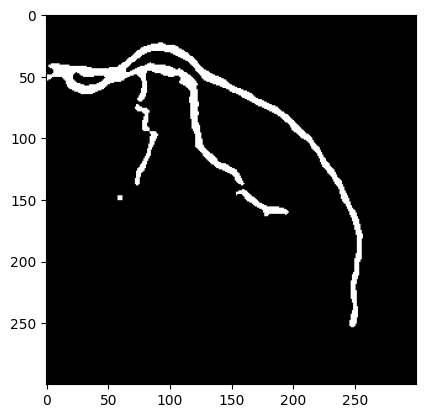

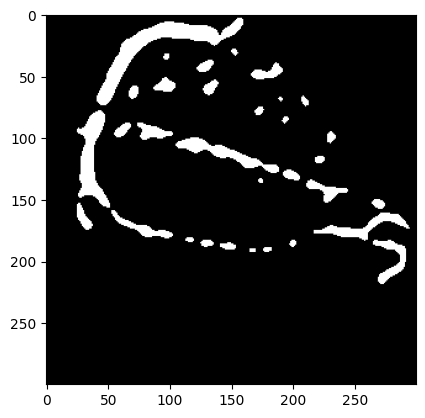

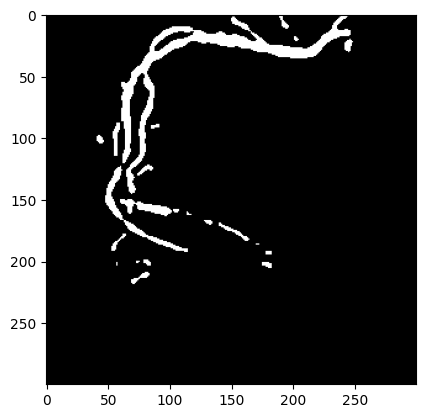

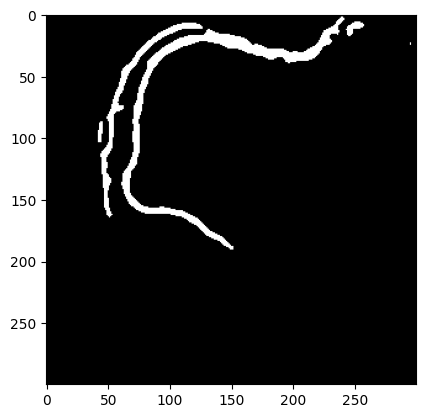

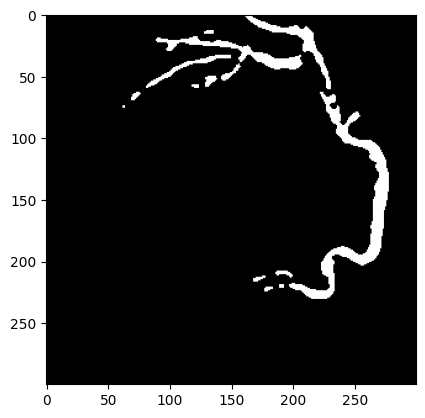

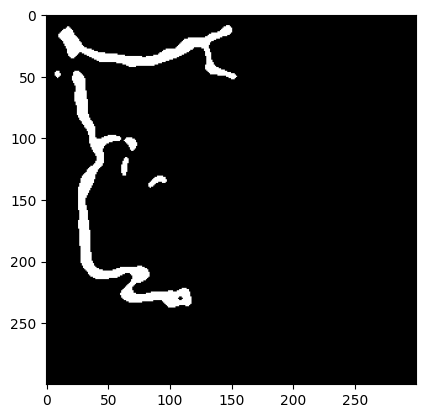

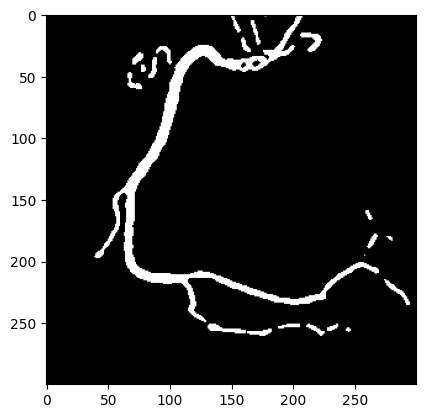

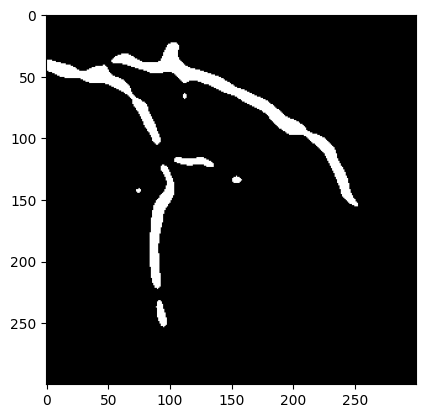

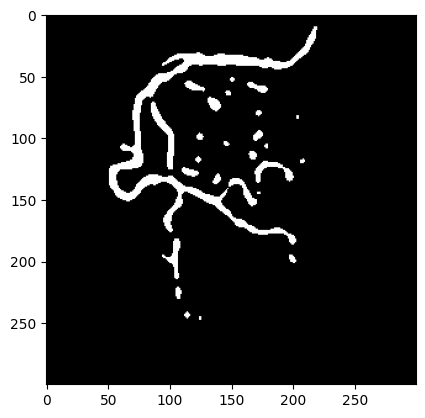

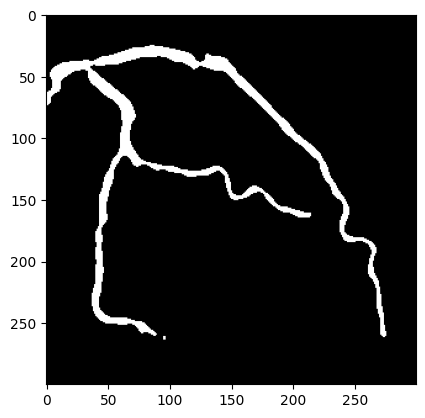

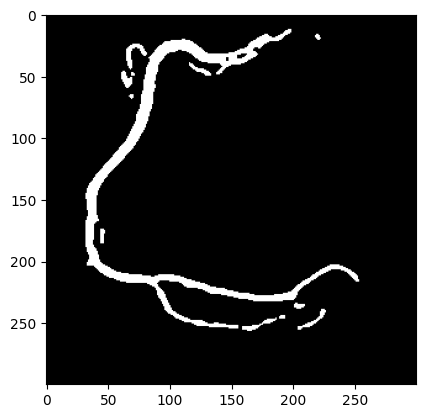

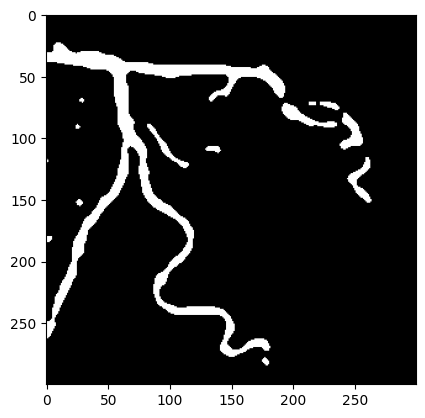

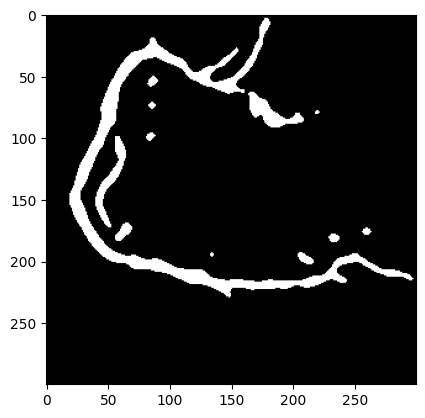

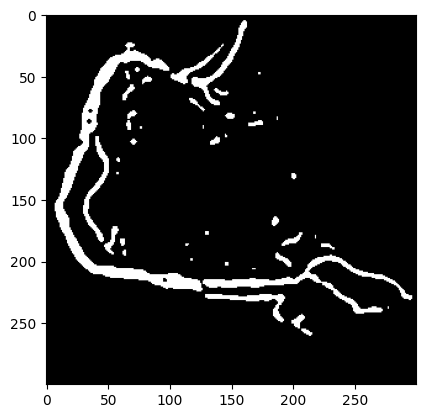

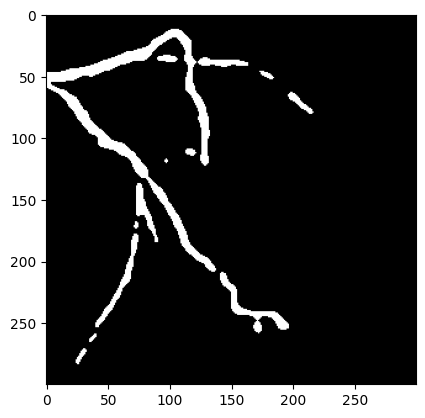

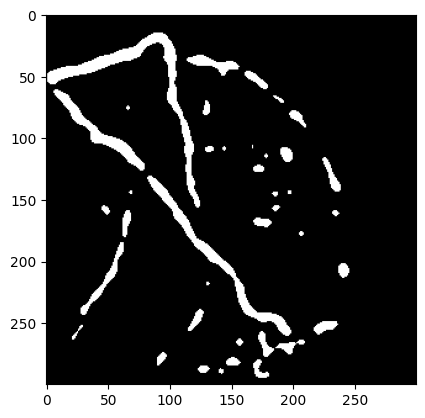

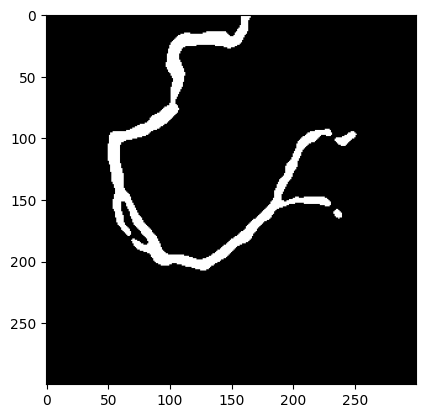

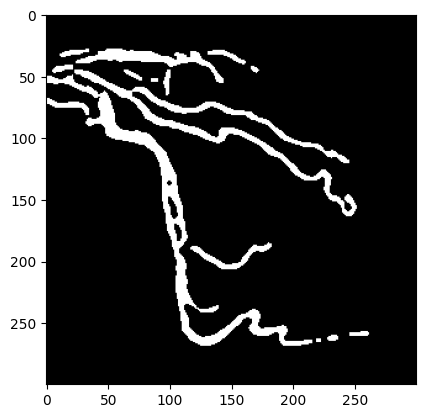

In [185]:
results = []
levels = [0.8] * 20
levels[7] = 0.7
levels[9] = 0.65
levels[10] = 0.85
levels[11] = 0.9
levels[14] = 0.92
levels[17] = 0.7

sigma = [2] * 20
sigma[3] = 4
sigma[7] = 4
sigma[9] = 5
sigma[10] = 3
sigma[11] = 4
sigma[13] = 4
sigma[14] = 4
sigma[16] = 3
sigma[17] = 4
sigma[18] = 4
for i in range(1, 21):
    image_path = 'database/' + str(i) + '.pgm'
    gt_path = 'database/' + str(i) + '_gt.pgm'
    image = cv2.imread(image_path, 0)
    gt = cv2.imread(gt_path, 0)
    image = normalize_image(image)
    gt = normalize_image(gt)
    # if i == 15:
    #     image = pipeline(image, level=0.92)
    #     #show_image(image)
    # else:
    image = pipeline(image, level=levels[i-1], sigma=sigma[i-1])
    show_image(image)
    save_image(image, f'loc_images/{i}_binarized.png')
    accuracy, recall, specificity, precision, f1 = compute_metrics(gt, image)
    result = {'image': i, 
              'accuracy': accuracy, 
              'recall': recall, 
              'specificity': specificity,
              'precision': precision,
              'f1': f1}
    results.append(result)

In [186]:
results_dict = pd.DataFrame(results)
results_dict.to_csv('datasets_binarization/result_loc.csv', index=False)
print(results_dict)

    image  accuracy    recall  specificity  precision        f1
0       1  0.976778  0.738429     0.987230   0.717185  0.727652
1       2  0.971556  0.761299     0.981971   0.676569  0.716438
2       3  0.980422  0.839352     0.986583   0.732052  0.782039
3       4  0.947333  0.708323     0.958383   0.440363  0.543088
4       5  0.970522  0.721966     0.979849   0.573450  0.639195
5       6  0.976711  0.729129     0.986081   0.664722  0.695437
6       7  0.968700  0.634086     0.986023   0.701373  0.666034
7       8  0.979978  0.782805     0.989627   0.786928  0.784862
8       9  0.973667  0.796858     0.983153   0.717344  0.755013
9      10  0.972333  0.760892     0.982034   0.660220  0.706990
10     11  0.964233  0.674952     0.976500   0.549111  0.605563
11     12  0.954533  0.593216     0.985639   0.780524  0.674100
12     13  0.979978  0.901397     0.983233   0.690120  0.781734
13     14  0.958000  0.758765     0.973371   0.687324  0.721280
14     15  0.959389  0.809146     0.9671

In [187]:
results_dict.describe()

,image,accuracy,recall,specificity,precision,f1
count,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,10.50000,0.968109,0.755602,0.979326,0.659772,0.700453
std,5.91608,0.009407,0.072439,0.008044,0.086064,0.064480
min,1.00000,0.947333,0.593216,0.958383,0.440363,0.543088
25%,5.75000,0.962522,0.724508,0.975398,0.624682,0.664943
50%,10.50000,0.969611,0.759828,0.982003,0.681947,0.711714
75%,15.25000,0.974428,0.799930,0.985735,0.708966,0.745773
max,20.00000,0.980422,0.901397,0.989627,0.786928,0.784862
